In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler

In [739]:
df = pd.read_parquet("trots_2013-2022.parquet")

## Clean Data

In [740]:
# Remove whitespace inside the string values in the FinishPosition column
df["FinishPosition"] = df["FinishPosition"].str.strip()

In [741]:
df.shape

(1200412, 43)

In [742]:
# Remove rows where Disqualified is True, but FinishPosition is an integer
mask = (df["Disqualified"] == True) & (df["FinishPosition"].str.isnumeric())
df = df[~mask]

In [743]:
df.shape

(1190331, 43)

In [744]:
# Categorize non-numerical values inside FinishPosition under being disqualified, or as 0
df.loc[df["FinishPosition"].str.isalpha(), "FinishPosition"] = '0'

In [745]:
# Convert FinishPosition column to be of integer type
df["FinishPosition"] = pd.to_numeric(df["FinishPosition"])

In [746]:
# Drop irrelevant Standard columns
df = df.drop(['ClassRestriction', 'FoalingCountry', 'FoalingDate', 'AgeRestriction'], axis=1)
# df = df.drop(['FoalingCountry', 'FoalingDate'], axis=1)

# Drop ID columns (too much variance)
# df = df.drop(['DamID', 'GoingID', 'HorseID', 'JockeyID', 'RaceID', 'SireID', 'TrackID', 'TrainerID'], axis=1)
df = df.drop(['DamID', 'GoingID', 'JockeyID', 'SireID', 'TrackID', 'TrainerID'], axis=1)

In [747]:
# Drop irrelevant Performance columns
df = df.drop(['NoFrontCover', 'PositionInRunning', 'WideOffRail', 'PriceSP', 'Prizemoney', 'Disqualified', 'PIRPosition'], axis=1)

In [748]:
# Drop columns with too many empty values
df = df.drop(['CourseIndicator', 'HandicapType', 'SexRestriction', 'RaceGroup'], axis=1)

In [749]:
# Combine HandicapDistance with Distance
df["Distance"] = df["Distance"] + df["HandicapDistance"]

In [750]:
# Drop HandicapDistance since it is already used
df = df.drop("HandicapDistance", axis=1)

Be mindful to convert categorical data into columns of the type 'category'

In [751]:
# Handle columns with categorical data (Gender, GoingAbbrev, RacingSubType, SaddleCloth, StartType, Surface)
# Converting type of columns to category 
# df['AgeRestriction'] = df['AgeRestriction'].astype('category')
# df['ClassRestriction'] = df['ClassRestriction'].astype('category')
df['Gender'] = df['Gender'].astype('category') 
df['GoingAbbrev'] = df['GoingAbbrev'].astype('category')
df['RacingSubType'] = df['RacingSubType'].astype('category') 
df['Saddlecloth'] = df['Saddlecloth'].astype('category') 
df['StartType'] = df['StartType'].astype('category') 
df['Surface'] = df['Surface'].astype('category') 

# Convert categorical values into numerical values
# df['AgeRestriction'] = df['AgeRestriction'].cat.codes
# df['ClassRestriction'] = df['ClassRestriction'].cat.codes
df['Gender'] = df['Gender'].cat.codes 
df['GoingAbbrev'] = df['GoingAbbrev'].cat.codes 
df['RacingSubType'] = df['RacingSubType'].cat.codes 
df['Saddlecloth'] = df['Saddlecloth'].cat.codes 
df['StartType'] = df['StartType'].cat.codes 
df['Surface'] = df['Surface'].cat.codes 

# Convert categorical columns to be of category type again
# df['AgeRestriction'] = df['AgeRestriction'].astype('category')
# df['ClassRestriction'] = df['ClassRestriction'].astype('category')
df['Gender'] = df['Gender'].astype('category') 
df['GoingAbbrev'] = df['GoingAbbrev'].astype('category')
df['RacingSubType'] = df['RacingSubType'].astype('category') 
df['Saddlecloth'] = df['Saddlecloth'].astype('category') 
df['StartType'] = df['StartType'].astype('category') 
df['Surface'] = df['Surface'].astype('category') 

# df['DamID'] = df['DamID'].astype('category') 
# df['GoingID'] = df['GoingID'].astype('category')
# df['HorseID'] = df['HorseID'].astype('category') 
# df['JockeyID'] = df['JockeyID'].astype('category') 
# df['RaceID'] = df['RaceID'].astype('category') 
# df['SireID'] = df['SireID'].astype('category') 
# df['TrackID'] = df['TrackID'].astype('category') 
# df['TrainerID'] = df['TrainerID'].astype('category')

df['Barrier'] = df['Barrier'].astype('category') 
df['FrontShoes'] = df['FrontShoes'].astype('category') 
df['HindShoes'] = df['HindShoes'].astype('category') 

In [752]:
# Reset index of the dataframe
df = df.reset_index(drop=True)

## Set Up Target Label

Get each horse's cumulative average race position quantile, cumulative here means for each race/row, get the cumulative average quantile from all previous races up until the current race
- A race position quantile is calculated by: FinishPosition/TotalHorseCountPerRace
- The lower the race position quantile, the better 
- Note:
    - For first-timers, the cumulative average race position quantile is just the race position quantile that the horse achieved in that first race
    - For disqualified horses, the current race position quantile that they achieved is considered as 1

In [753]:
# Sort df based on race date
df.sort_values(by=['HorseID', 'RaceStartTime'], inplace=True)

# Get number of horses in each race as a separate column
df['HorseCountPerRace'] = df.groupby('RaceID')['RaceID'].transform('count')

# Get each horse's cumulative count of races from all previous races and the current race combined
df['CumulativeRaceCountPerHorse'] = df.groupby('HorseID')['RaceID'].cumcount() + 1

In [754]:
# Get each horse's current race position quantile 
df['CurrentPositionQuantile'] = df['FinishPosition'] / df['HorseCountPerRace']
# Ensure the disqualified horses to get a quantile of 1 (max value), and not 0
df['CurrentPositionQuantile'] = df['CurrentPositionQuantile'].replace(0, 1)

In [755]:
# Get each horse's cumulative sum of all race position quantiles from all previous races and the current race combined
df['CumulativeTotalPositionQuantile'] = df.groupby('HorseID')['CurrentPositionQuantile'].cumsum()

In [756]:
# Get each horse's cumulative average race position quantile from all previous races and the current race combined
df['CumulativeAveragePositionQuantile'] = df['CumulativeTotalPositionQuantile'] / df['CumulativeRaceCountPerHorse']

### Add a new input column for previous cumulative average race position quantile, excluding current race

In [757]:
# Add a new input column for previous cumulative average race position quantile, excluding current race
df['PastAveragePositionQuantile'] = (df['CumulativeTotalPositionQuantile'] - df['CurrentPositionQuantile']) / (df['CumulativeRaceCountPerHorse'] - 1)
# df['PastAveragePositionQuantile'] = df['PastAveragePositionQuantile'].fillna(0.5)

In [758]:
# df[(df['HorseID'] == 1504469)][['RaceID', 'FinishPosition', 'HorseCountPerRace', 'CumulativeRaceCountPerHorse', 'CurrentPositionQuantile', 'CumulativeTotalPositionQuantile', 'CumulativeAveragePositionQuantile', 'PastAveragePositionQuantile']]
# df[(df['RaceID'] == 1583261)][['HorseID', 'FinishPosition', 'HorseCountPerRace', 'CumulativeRaceCountPerHorse', 'CurrentPositionQuantile', 'CumulativeTotalPositionQuantile', 'CumulativeAveragePositionQuantile']]

In [759]:
# Remove used Performance columns
df = df.drop(['BeatenMargin', 'RaceOverallTime', 'FinishPosition'], axis=1)
df = df.drop(['HorseCountPerRace', 'CumulativeRaceCountPerHorse', 'CurrentPositionQuantile', 'CumulativeTotalPositionQuantile'], axis=1)

In [760]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1190331 entries, 62421 to 270780
Data columns (total 20 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   Barrier                            1190331 non-null  category      
 1   Distance                           1190331 non-null  float64       
 2   FrontShoes                         1190331 non-null  category      
 3   Gender                             1190331 non-null  category      
 4   GoingAbbrev                        1190331 non-null  category      
 5   HindShoes                          1190331 non-null  category      
 6   HorseAge                           1190331 non-null  int64         
 7   HorseID                            1190331 non-null  int64         
 8   RaceID                             1190331 non-null  int64         
 9   RacePrizemoney                     1190331 non-null  float64       
 10  RaceStar

## Split Data

Split training and validation set according to the guideline given, which is to train the model using data before Nov 1, 2021

In [761]:
train = df[(df["RaceStartTime"] < datetime.datetime(2021, 11, 1))]
val = df[(df["RaceStartTime"] >= datetime.datetime(2021, 11, 1))]

In [762]:
train = train.drop("RaceStartTime", axis=1)
val = val.drop("RaceStartTime", axis=1)

In [763]:
X_train = train.loc[:, train.columns != "CumulativeAveragePositionQuantile"]
X_val = val.loc[:, val.columns != "CumulativeAveragePositionQuantile"]
y_train = train["CumulativeAveragePositionQuantile"]
y_val = val["CumulativeAveragePositionQuantile"]

In [764]:
# Reset index of the datasets
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [765]:
# Extract HorseID and RaceID to be merged back at the end with the validation set
impt_ids = X_val[["HorseID", "RaceID"]]
# Get rid of the remaining ID columns to reduce data variance
X_train = X_train.drop(['HorseID', 'RaceID'], axis=1)
X_val = X_val.drop(['HorseID', 'RaceID'], axis=1)

In [766]:
X_train.shape

(1162445, 16)

In [767]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162445 entries, 0 to 1162444
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   Barrier                      1162445 non-null  category
 1   Distance                     1162445 non-null  float64 
 2   FrontShoes                   1162445 non-null  category
 3   Gender                       1162445 non-null  category
 4   GoingAbbrev                  1162445 non-null  category
 5   HindShoes                    1162445 non-null  category
 6   HorseAge                     1162445 non-null  int64   
 7   RacePrizemoney               1162445 non-null  float64 
 8   RacingSubType                1162445 non-null  category
 9   Saddlecloth                  1162445 non-null  category
 10  StartType                    1162445 non-null  category
 11  StartingLine                 1162445 non-null  int64   
 12  Surface                     

## Train Model

### Normalize Dataset

NOTE: Unnormalized data performs better!

In [768]:
# scaler = StandardScaler()
# X_train_norm = scaler.fit_transform(X_train)
# X_val_norm = scaler.fit_transform(X_val)

### Build Model

We are using XGBoost to model the dataset

In [769]:
params = {
    'learning_rate': 0.7, 
    'eval_metric': 'logloss',
    # Increase max_depth to get more complex models, start with 3 (keep at 3)
    'max_depth': 5,
    # Decrease subsample till 0.5 to decrease fraction of observations used for each tree and to prevent overfitting (keep at 1)
    'subsample': 1,
    # Decrease colsample_bytree till 0.5 to decrease fraction of features used for each tree and to prevent overfitting (keep at 1)
    'colsample_bytree': 0.8,
    # Increase to increase L2 regularization and avoid overfitting (keep at 0.6)
    'lambda': 0.8,
    # Increase to increase L1 regularization and avoid overfitting (keep at 0)
    'alpha': 0.3,
    # Increase till 1000 to increase #trees in the model to improve model performance, but don't overfit (doesn't change)
    # 'n_estimators': 250
}

# model = xgb.train(params, dtrain=xgb.DMatrix(X_train_norm, y_train, enable_categorical=True))
model = xgb.train(params, dtrain=xgb.DMatrix(X_train, y_train, enable_categorical=True))


### Evaluate Model

In [770]:
y_pred = model.predict(xgb.DMatrix(X_val, enable_categorical=True))
# y_pred = model.predict(xgb.DMatrix(X_val_norm, enable_categorical=True))

print('MSE Result with XGBoost: {}'.format(mean_squared_error(y_val, y_pred)))

r2 = r2_score(y_val, y_pred)
print('R-squared:', r2)

MSE Result with XGBoost: 0.004362366604090642
R-squared: 0.7635253638859167


### Obtain Feature Importance

Display the Feature Importance Results by Weight, Gain, and Cover

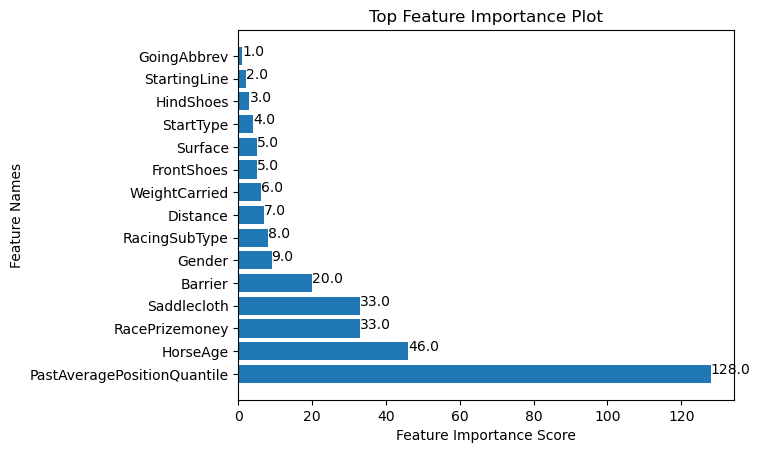

In [771]:
# By Weight
feature_importance = model.get_fscore()

sorted_feature_importance = sorted(feature_importance.items(), key=lambda x:x[1], reverse=True)

feature_names, feature_importance_values = zip(*sorted_feature_importance) # unpack a list of pairs into two tuples

plt.barh(feature_names[:15], feature_importance_values[:15])
for i, v in enumerate(feature_importance_values[:15]):
    plt.text(v, i, str(v))
plt.title("Top Feature Importance Plot")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Names")
plt.show()

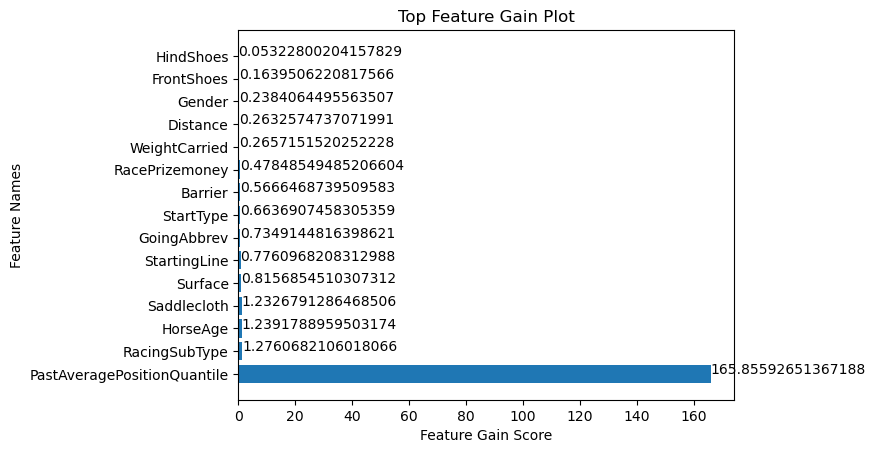

In [772]:
# By Gain
gscore = model.get_score(importance_type='gain')

sorted_gscore = sorted(gscore.items(), key=lambda x:x[1], reverse=True)

gain_names, gain_importance_values = zip(*sorted_gscore) # unpack a list of pairs into two tuples

plt.barh(gain_names, gain_importance_values)
for i, v in enumerate(gain_importance_values):
    plt.text(v, i, str(v))
plt.title("Top Feature Gain Plot")
plt.xlabel("Feature Gain Score")
plt.ylabel("Feature Names")
plt.show()

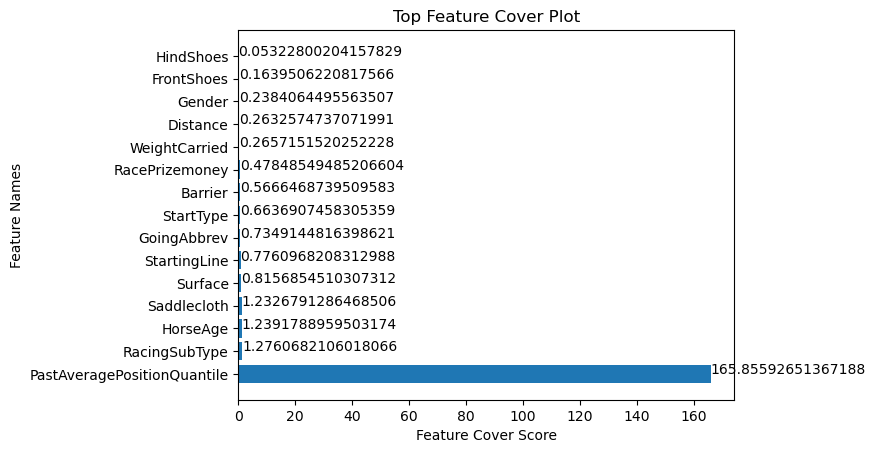

In [773]:
# By Coverage
cscore = model.get_score(importance_type='cover')

sorted_cscore = sorted(gscore.items(), key=lambda x:x[1], reverse=True)

feature_names, cover_importance_values = zip(*sorted_cscore) # unpack a list of pairs into two tuples

plt.barh(feature_names, cover_importance_values)
for i, v in enumerate(cover_importance_values):
    plt.text(v, i, str(v))
plt.title("Top Feature Cover Plot")
plt.xlabel("Feature Cover Score")
plt.ylabel("Feature Names")
plt.show()

### Get Predicted Win Probability

In [774]:
# Invert the quantile ranking to get a probability score (higher is better)
pred_win_prob = 1 - y_pred
pred_win_prob = pd.DataFrame(pred_win_prob, columns = ['winprobability'])

In [775]:
# Combine HorseID and RaceID back to the validation set
X_val = X_val.merge(impt_ids, left_index=True, right_index=True)

In [776]:
# Combine the predicted win probability to the validation set
X_val = X_val.merge(pred_win_prob, left_index=True, right_index=True)

In [777]:
# Normalize win probability to sum up to 1
X_val['winprobability'] = X_val.groupby('RaceID')['winprobability'].transform(lambda x: x / x.sum())

In [784]:
# Export validation set with predicted win probabilities as a csv file
X_val.to_parquet("pred_win_prob_validation_set.parquet")

In [779]:
# Calculate actual win label for validation set
y_val2 = 1 - y_val

X_val = X_val.merge(y_val2.to_frame(), left_index=True, right_index=True)
X_val = X_val.rename({'CumulativeAveragePositionQuantile': 'ActualWinProbability'}, axis=1)
X_val['ActualWinProbability'] = X_val.groupby('RaceID')['ActualWinProbability'].transform(lambda x: x / x.sum())

max_values = X_val.groupby('RaceID')['ActualWinProbability'].transform('max')
X_val['WinLabel'] = (X_val['ActualWinProbability'] == max_values).astype(int)

In [781]:
X_val[(X_val["RaceID"] == 1710630)][['HorseID', 'ActualWinProbability', 'winprobability', 'WinLabel']]

,HorseID,ActualWinProbability,winprobability,WinLabel
24532,1565002,0.049005,0.066888,0
26583,1575345,0.058490,0.095973,0
27166,1589298,0.143378,0.138519,0
27199,1594647,0.103923,0.131915,0
27372,1603211,0.061224,0.070010,0
27635,1628811,0.128727,0.138558,0
27645,1628817,0.204079,0.192017,1
27884,1631931,0.150704,0.081934,0
27885,1631932,0.100470,0.084186,0


In [782]:
# Compute log-loss result
print('LogLoss Result: {}'.format(log_loss(X_val["WinLabel"], X_val["winprobability"])))

LogLoss Result: 0.24552968449058318


## Data Exploration

In [ ]:
# df.info()

In [ ]:
# df[["AgeRestriction", "Barrier", "ClassRestriction", "CourseIndicator", "DamID", "Distance", "FoalingCountry", "FoalingDate", "FrontShoes", "Gender", "GoingAbbrev", "GoingID", "HandicapDistance", "HandicapType", "HindShoes", "HorseAge", "HorseID", "JockeyID", "RaceGroup", "RaceID", "RacePrizemoney", "RaceStartTime", "RacingSubType", "Saddlecloth", "SexRestriction", "SireID", "StartType", "StartingLine", "Surface", "TrackID", "TrainerID", "WeightCarried", "WetnessScale"]].head()

In [54]:
# df[(df["RaceID"] == 1592716)][["AgeRestriction", "Barrier", "ClassRestriction", "CourseIndicator", "DamID", "Distance", "FoalingCountry", "FoalingDate", "FrontShoes", "Gender"]]

,AgeRestriction,Barrier,ClassRestriction,CourseIndicator,DamID,Distance,FoalingCountry,FoalingDate,FrontShoes,Gender
8,6-9yo,0,NW$165 CF,,1479721,2375.0,FR,2005-03-11,0,M
9,6-9yo,0,NW$165 CF,,1480787,2375.0,FR,2007-03-26,0,M
10,6-9yo,0,NW$165 CF,,1492077,2375.0,FR,2006-05-21,0,M
11,6-9yo,0,NW$165 CF,,1481574,2375.0,FR,2006-05-01,0,M
12,6-9yo,0,NW$165 CF,,1475946,2375.0,FR,2005-03-20,1,M
652641,6-9yo,0,NW$165 CF,,1504468,2375.0,FR,2008-05-26,0,M
652642,6-9yo,0,NW$165 CF,,1502197,2375.0,FR,2008-05-16,0,M
652643,6-9yo,0,NW$165 CF,,1480121,2375.0,FR,2007-05-01,0,F
652644,6-9yo,0,NW$165 CF,,1486063,2375.0,FR,2008-04-12,0,M
652645,6-9yo,0,NW$165 CF,,1504771,2375.0,FR,2008-05-20,0,F


In [55]:
# df[(df["RaceID"] == 1592716)][["GoingAbbrev", "GoingID", "HandicapDistance", "HandicapType", "HindShoes", "HorseAge", "HorseID", "JockeyID", "RaceGroup", "RaceID"]]

,GoingAbbrev,GoingID,HandicapDistance,HandicapType,HindShoes,HorseAge,HorseID,JockeyID,RaceGroup,RaceID
8,SO,9,25.0,,0,9,1490049,23892,,1592716
9,SO,9,0.0,,0,7,1480788,22363,,1592716
10,SO,9,0.0,,0,8,1492078,22646,,1592716
11,SO,9,0.0,,0,8,1499889,22653,,1592716
12,SO,9,25.0,,0,9,1475947,22673,,1592716
652641,SO,9,25.0,,0,6,1504469,22453,,1592716
652642,SO,9,25.0,,0,6,1502198,22667,,1592716
652643,SO,9,0.0,,0,7,1496121,22648,,1592716
652644,SO,9,25.0,,0,6,1505720,22658,,1592716
652645,SO,9,0.0,,0,6,1504772,23145,,1592716


In [75]:
# df[(df["RaceID"] == 1592716)][["RacePrizemoney", "RaceStartTime", "RacingSubType", "Saddlecloth", "SexRestriction", "SireID"]]

,RacePrizemoney,RaceStartTime,RacingSubType,Saddlecloth,SexRestriction,SireID
8,25000.0,2014-11-09 16:20:00,T,11,,1478525
9,25000.0,2014-11-09 16:20:00,T,6,,1477050
10,25000.0,2014-11-09 16:20:00,T,4,,1474459
11,25000.0,2014-11-09 16:20:00,T,5,,1475301
12,25000.0,2014-11-09 16:20:00,T,14,,1475945
652641,25000.0,2014-11-09 16:20:00,T,12,,1474416
652642,25000.0,2014-11-09 16:20:00,T,10,,1499273
652643,25000.0,2014-11-09 16:20:00,T,3,,1474533
652644,25000.0,2014-11-09 16:20:00,T,9,,1476058
652645,25000.0,2014-11-09 16:20:00,T,2,,1475664


In [57]:
# df[(df["RaceID"] == 1592716)][["StartType", "StartingLine", "Surface", "TrackID", "TrainerID", "WeightCarried", "WetnessScale"]]

,StartType,StartingLine,Surface,TrackID,TrainerID,WeightCarried,WetnessScale
8,V,-1,S,927,38096,0.0,7
9,V,-1,S,927,39680,0.0,7
10,V,-1,S,927,38612,0.0,7
11,V,-1,S,927,40472,0.0,7
12,V,-1,S,927,40047,0.0,7
652641,V,-1,S,927,38065,0.0,7
652642,V,-1,S,927,38091,0.0,7
652643,V,-1,S,927,38203,0.0,7
652644,V,-1,S,927,38077,0.0,7
652645,V,-1,S,927,38394,0.0,7


In [58]:
# df[(df["RaceID"] == 1592716)][["BeatenMargin", "Disqualified", "FinishPosition", "PIRPosition", "Prizemoney", "RaceOverallTime", "PriceSP", "NoFrontCover", "PositionInRunning", "WideOffRail"]]

,BeatenMargin,Disqualified,FinishPosition,PIRPosition,Prizemoney,RaceOverallTime,PriceSP,NoFrontCover,PositionInRunning,WideOffRail
8,23.60,False,10,0,0.0,185.1,0.0,-9,-9,-9
9,999.00,False,BS,0,0.0,185.1,0.0,-9,-9,-9
10,25.60,False,UN,0,0.0,185.1,0.0,-9,-9,-9
11,999.00,False,BS,0,0.0,185.1,0.0,-9,-9,-9
12,999.00,False,BS,0,0.0,185.1,0.0,-9,-9,-9
652641,0.00,False,1,0,11250.0,185.1,0.0,-9,-9,-9
652642,4.65,False,2,0,6250.0,185.1,0.0,-9,-9,-9
652643,5.55,False,3,0,3500.0,185.1,0.0,-9,-9,-9
652644,7.40,False,4,0,2000.0,185.1,0.0,-9,-9,-9
652645,7.85,False,5,0,1250.0,185.1,0.0,-9,-9,-9
